# Analysis and figures

Saoirse Kelleher  
September 25, 2024

Calculates key statistics and renders figures for “*Twenty years of dynamic occupancy models: a review of applications and look to the future*”

## Load packages

First, we load in a handful of packages required for analysis and visualisation.

In [ ]:

library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE

## Read in data

Two data sources are required to render the analyses and visualisation for this article:

1.  Randomised list of all queried articles *(Randomisation.xlsx)*

2.  Spreadsheet of articles included in the review *(Review_Spreadsheet.xlsx)*

#### Randomised article list

All queried articles were collated and assigned random values in *‘Randomisation.qmd’* to determine the order in which they would be considered for inclusion. ’*Randomisation.xlsx’* contains all of these articles, and also documents which articles were included in the review, were excluded based on our review criteria, or were not processed at all. This spreadsheet is split across sheets by year strata. All sheets are read in using `readxl` and combined.

In [ ]:
sheet_AllArticles <- list(read_xlsx("Randomisation/Randomisation.xlsx", 
                                    sheet = "2004-2007"),
                          read_xlsx("Randomisation/Randomisation.xlsx", 
                                    sheet = "2008-2011"),
                          read_xlsx("Randomisation/Randomisation.xlsx", 
                                    sheet = "2012-2015"),
                          read_xlsx("Randomisation/Randomisation.xlsx", 
                                    sheet = "2016-2019"),
                          read_xlsx("Randomisation/Randomisation.xlsx", 
                                    sheet = "2020-2023")) |> 
  list_rbind()


#### Reviewed data

*‘Review_Spreadsheet.xlsx’* contains all recorded details from the 92 reviewed articles. This spreadsheet contains several sheets, each including one category of variable (e.g., details on ‘Focal Taxa’ or ‘Covariates’). Each of these is loaded individually with `readxl`.

In [ ]:
sheet_ArticleData <- read_xlsx("Review_Spreadsheet.xlsx",
                               sheet = "Article Data")
sheet_Objectives <- read_xlsx("Review_Spreadsheet.xlsx",
                              sheet = "Objectives") 
sheet_FocalTaxa <- read_xlsx("Review_Spreadsheet.xlsx",
                             sheet = "Focal Taxa") 
sheet_StudyArea <- read_xlsx("Review_Spreadsheet.xlsx",
                             sheet = "Study Area")
sheet_DataCollection <- read_xlsx("Review_Spreadsheet.xlsx",
                                  sheet = "Data Collection")
sheet_Covariates <- read_xlsx("Review_Spreadsheet.xlsx",
                              sheet = "Covariates")
sheet_Modelling <- read_xlsx("Review_Spreadsheet.xlsx",
                             sheet = "Modelling")


## Article inclusion

The first set of numbers we calculate describe the articles included in the review, and the inclusion rates within each of our year strata. These values are used to render a figure showing the coverage of reviewed articles during our study period.

#### Articles by query

Recall that our review sample was drawn from two Web of Science queries: the first being all articles which have cited MacKenzie et al. ([2003](#ref-mackenzie2003)), and the second using a selection of keywords presumed to be used in articles fitting DOMs. Here, we calculate the number of articles which appeared in one or both of these queries.

In [ ]:
stat_queryCounts <- sheet_AllArticles |>
  mutate(Query = case_when(KeyTerms == TRUE & CitesMackenzie == TRUE ~ "Both",
                           KeyTerms == FALSE & CitesMackenzie == TRUE ~ "Mackenzie only",
                           KeyTerms == TRUE & CitesMackenzie == FALSE ~ "Key terms only")) |>
  summarise(Articles = n(), .by = Query) |>
  mutate(Proportion = round(Articles/sum(Articles), 2))
stat_queryCounts


# A tibble: 3 × 3
  Query          Articles Proportion
  <chr>             <int>      <dbl>
1 Both                298       0.2 
2 Mackenzie only      897       0.61
3 Key terms only      274       0.19

#### Total articles

Next, we get the number of articles included in the review.

In [ ]:
stat_articleTotal <- sheet_AllArticles |>
  filter(Included == "YES") |>
  nrow()
stat_articleTotal


[1] 92

#### Article hit rates

We then calculate the hit rate for articles in each stratum, by dividing the number of articles included by the number of articles processed. These hit rates are then used to estimate how many articles from the remaining pool would have met inclusion criteria — first summed from each year, then summed across years.

In [ ]:
# Hit rates within each stratum
stat_hitRates <- sheet_AllArticles |>
  summarise(Articles = n(), 
            .by = c(Year, Strata, Included)) |>
  pivot_wider(names_from = Included, 
              values_from = Articles, 
              values_fill = 0) |>
  summarise(HitRate = round(sum(YES)/(sum(NO)+sum(YES)), 2),
            .by = Strata)
stat_hitRates


# A tibble: 5 × 2
  Strata    HitRate
  <chr>       <dbl>
1 2004-2007    0.12
2 2008-2011    0.24
3 2012-2015    0.43
4 2016-2019    0.35
5 2020-2023    0.57

# A tibble: 20 × 2
    Year EstRemaining
   <dbl>        <dbl>
 1  2006         0   
 2  2007         0   
 3  2005         0   
 4  2004         0   
 5  2010         8.05
 6  2008         4.63
 7  2009         6.83
 8  2011        12.2 
 9  2015        34.0 
10  2013        30.6 
11  2012        28.9 
12  2014        31.9 
13  2019        35.8 
14  2018        32.6 
15  2017        30.5 
16  2016        23.5 
17  2021        60   
18  2023        42.3 
19  2022        52   
20  2020        61.7 

            Group Articles
1    EstRemaining    495.7
2 TotalUnreviewed   1152.0

#### Coverage figure

Using these values we render a figure presenting the estimated coverage of our review over time (Figure 3 in the article).

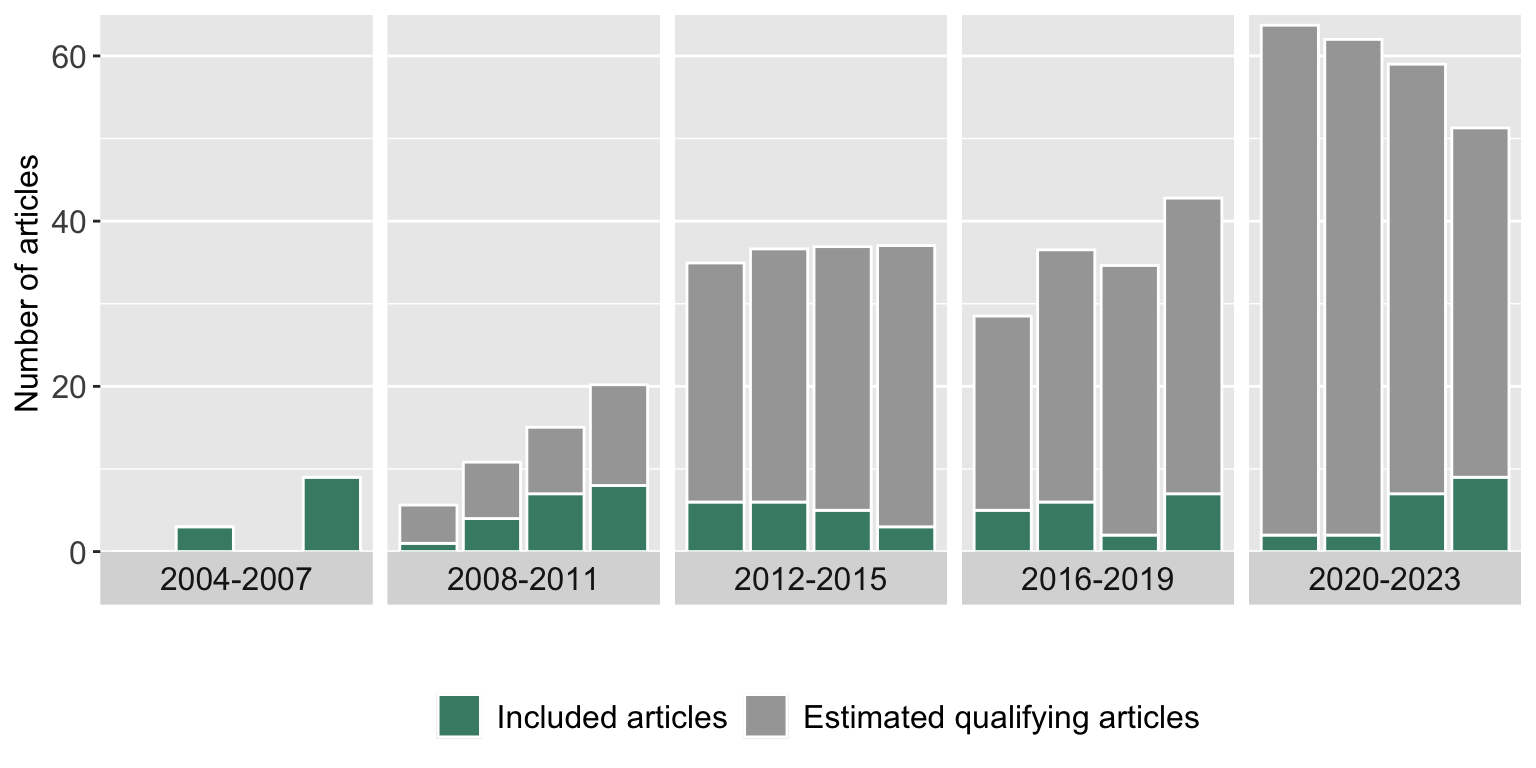

In [ ]:

plot_reviewCoverage <- 
  sheet_AllArticles |>
  summarise(N = n(), .by = c(Year, Strata, Included)) |>
  pivot_wider(names_from = Included, values_from = N, values_fill = 0) |>
  mutate(HitRate = sum(YES)/(sum(NO)+sum(YES)),
         .by = Strata) |>
  mutate(EstRemaining = `NA`*HitRate) |>
  pivot_longer(cols = c(YES, EstRemaining), 
               names_to = 'Group', values_to = 'Articles') |>
  
  ggplot() +
  geom_col(aes(x = Year, y = Articles, fill = Group), colour = "white") +
  scale_fill_manual("",
                    limits = c("YES", "EstRemaining"),
                    labels = c("Included articles", 
                               "Estimated qualifying articles"),
                    values = c("aquamarine4", "gray65")) +
  scale_y_continuous(expand = c(0,0), limits = c(0, 65)) +
  labs(x = "", y = "Number of articles") +
  theme(panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        legend.position = "bottom", 
        axis.text = element_text(size = 12),
        axis.text.x = element_blank(), 
        axis.ticks.x = element_blank(),
        axis.title = element_text(size = 12), 
        legend.text = element_text(size = 12),
        strip.text.x = element_text(size = 12)) +
  facet_grid(cols = vars(Strata), scales = "free_x", switch = "x")
plot_reviewCoverage


## Study areas

The next set of statistics and figures focus on the study areas included in reviewed articles. For each article the countries where data was collected, a rough centroid of the study area, and an estimate of the spatial extent of the study area was recorded.

#### Study countries table

First, a table is generated presenting the number of articles using data from each country with at least one article.

In [ ]:
stat_studyCountries <- sheet_StudyArea |>
  select(`Review ID`, Country) |>
  separate_longer_delim(Country, ", ") |>
  distinct() |>
  mutate(TotalArticles = length(unique(`Review ID`))) |>
  summarise(Articles = n(), .by = c(Country, TotalArticles)) |>
  mutate(Proportion = round(Articles/TotalArticles,2)) |>
  select(-TotalArticles) |>
  arrange(-Articles)
stat_studyCountries


# A tibble: 27 × 3
   Country                  Articles Proportion
   <chr>                       <int>      <dbl>
 1 United States of America       55       0.6 
 2 Canada                          6       0.07
 3 Italy                           5       0.05
 4 Switzerland                     5       0.05
 5 France                          4       0.04
 6 Australia                       4       0.04
 7 Brazil                          2       0.02
 8 Costa Rica                      2       0.02
 9 New Zealand                     2       0.02
10 Panama                          1       0.01
# ℹ 17 more rows

#### Unique countries

The total number of unique countries is extracted.

In [ ]:
stat_uniqueCountries <- stat_studyCountries$Country |>
  unique() |>
  length()
stat_uniqueCountries


[1] 27

#### Map of study locations

A figure is rendered plotting the rough centroids for each study area included in the review.

> **Some articles include multiple study areas which were treated as distinct when they were modelled independently.**

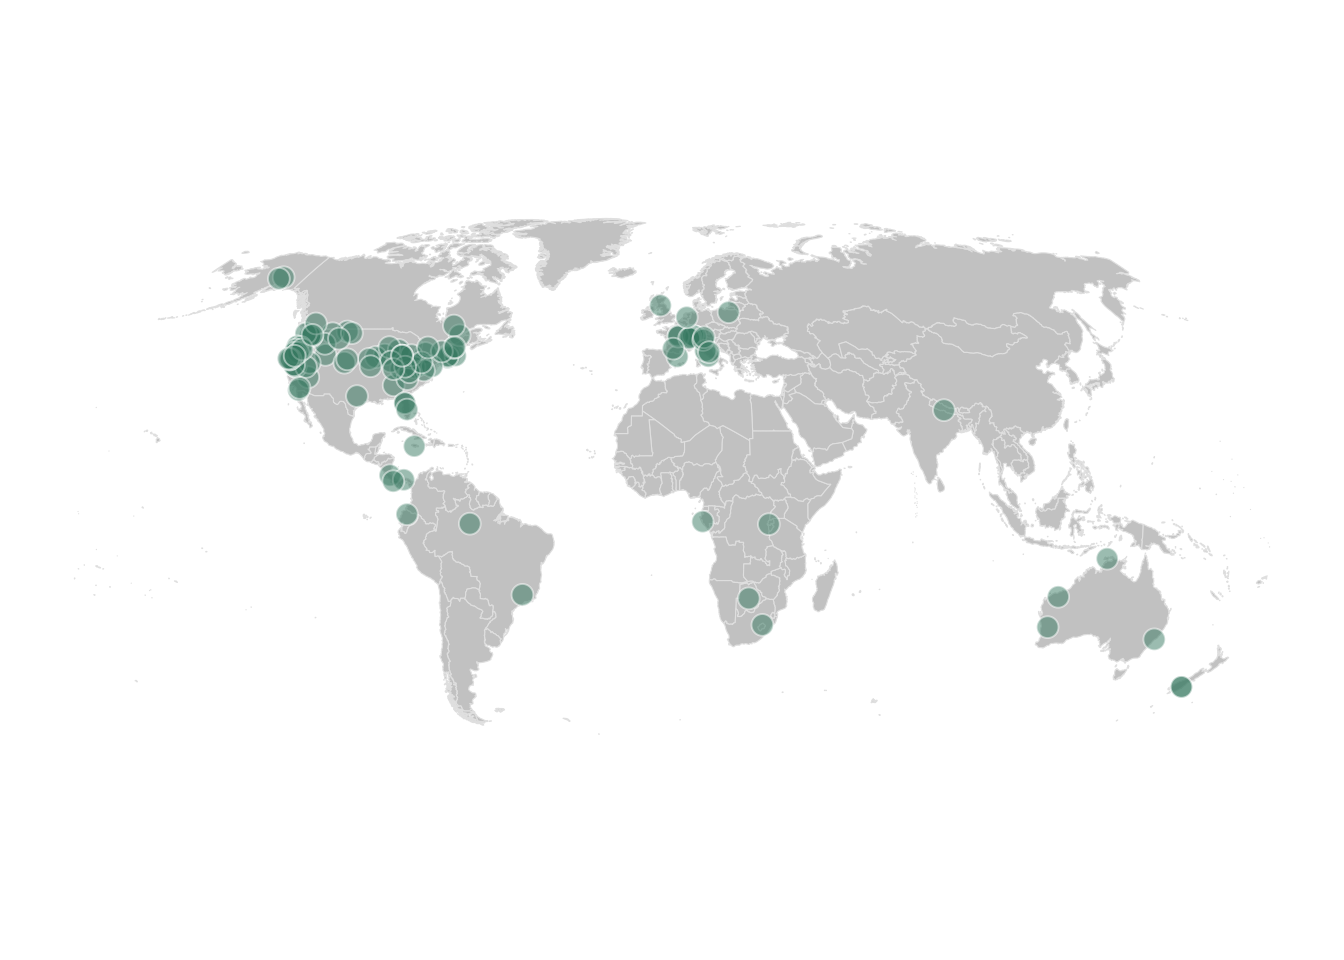

Saving 7 x 5 in image

In [ ]:
# Load country shapefile
countries_shp <- st_read("Analysis/Countries_Spatial/World_Countries__Generalized_.shp", quiet = TRUE) |>
  st_transform(crs = "ESRI:54030") |>
  filter(COUNTRY != "Antarctica")

studyArea_Map <- sheet_StudyArea |>
  st_as_sf(coords = c("Centre Point (lon)", "Centre Point (lat)"),
           crs = "EPSG:4326") |>
  st_transform(crs = "ESRI:54030") |>
  
  ggplot() +
  geom_sf(data = countries_shp, colour = "gray90", fill = "gray80") +
  geom_sf(shape = 21, fill = "aquamarine4", colour = "white", alpha = 0.5, size = 3.5) +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
        panel.background = element_rect(fill='transparent', color=NA),
        plot.background = element_rect(fill='transparent', color=NA),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank()) 
studyArea_Map


#### Study area size

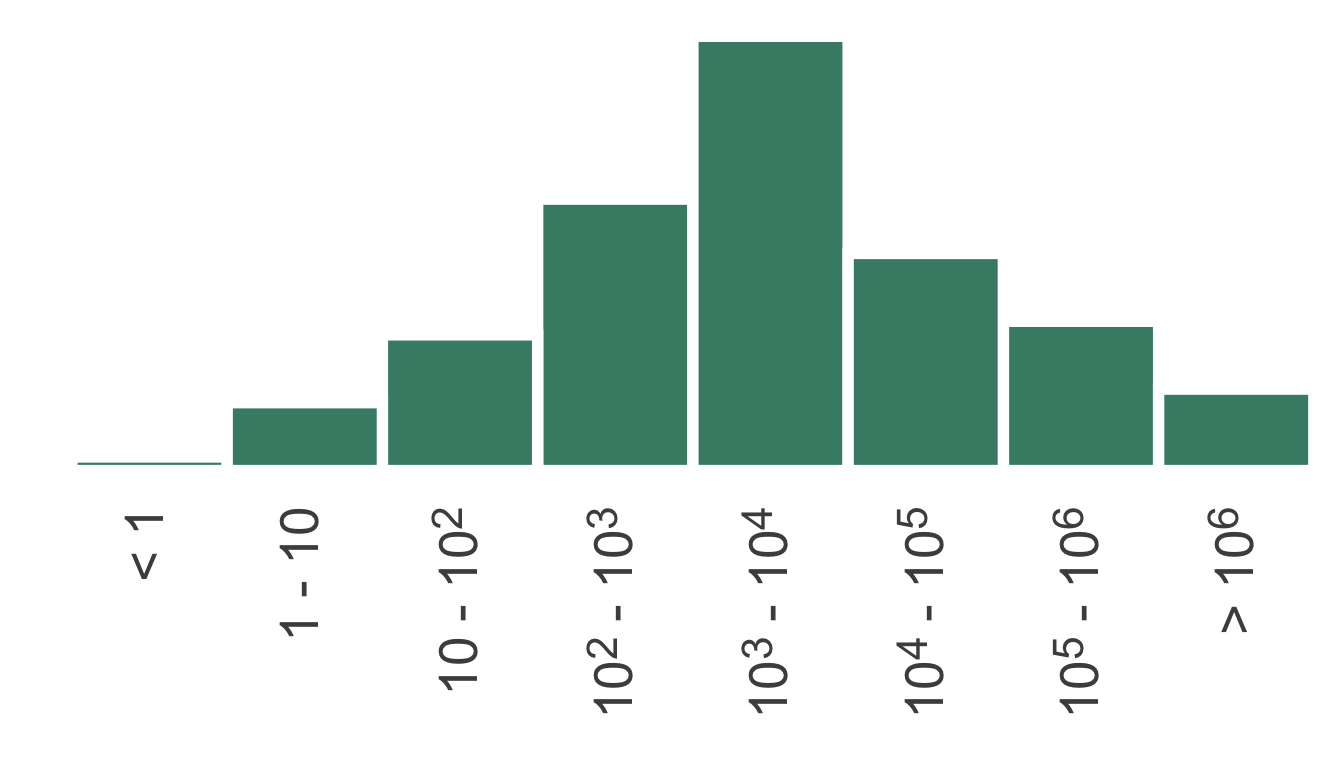

In [ ]:

studyAreaPlot <- sheet_StudyArea |>
  summarise(Articles = n(), .by = Size) |>
  filter(Size != "Unspecified") |>
  
  ggplot() +
  geom_col(aes(x = Size, y = Articles),
           fill = "aquamarine4", colour = "white",
           width = 1, linewidth = 2) +
  labs(x = "", y = "") +
  scale_x_discrete(labels = c("< 1", "1 - 10", "10 - 10<sup>2</sup>",
                              "10<sup>2</sup> - 10<sup>3</sup>",
                              "10<sup>3</sup> - 10<sup>4</sup>",
                              "10<sup>4</sup> - 10<sup>5</sup>",
                              "10<sup>5</sup> - 10<sup>6</sup>",
                              "\\> 10<sup>6</sup>")) +
  theme(panel.grid = element_blank(),
        axis.text.x = element_markdown(size = 20, angle = 90,
                                       vjust = 0.5, hjust = 1),
        axis.text.y = element_blank(), axis.ticks = element_blank(),
        panel.background = element_rect(fill='transparent', color=NA),
        plot.background = element_rect(fill='transparent', color=NA))
studyAreaPlot


## Study taxa

#### Multi-species statistics

In [ ]:
sheet_FocalTaxa |>
  separate_longer_delim(`Multispecies method`, ", ") |>
  select(`Review ID`, `Multispecies method`) |>
  distinct() |>
  mutate(TotalArticles = length(unique(`Review ID`))) |>
  summarise(Articles = n(), 
            .by = c(`Multispecies method`, TotalArticles)) |>
  mutate(Proportion = round(Articles/TotalArticles, 2))


# A tibble: 4 × 4
  `Multispecies method` TotalArticles Articles Proportion
  <chr>                         <int>    <int>      <dbl>
1 Independent                      92       31       0.34
2 Joint                            92        8       0.09
3 Single                           92       54       0.59
4 Interactive                      92        3       0.03

#### Study species

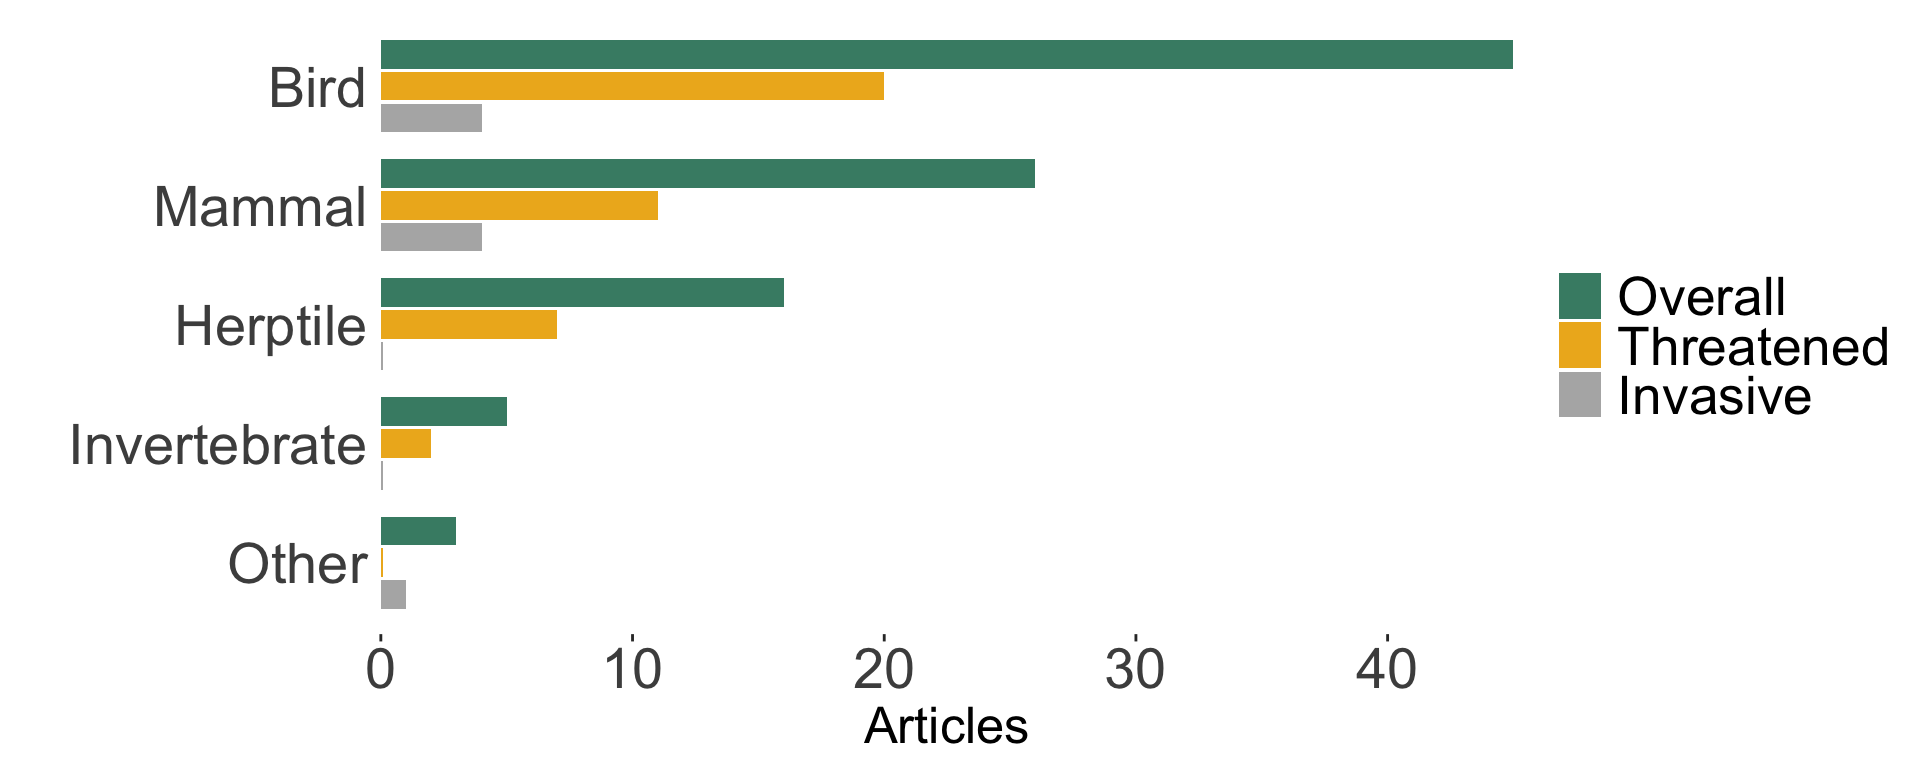

In [ ]:

focalTaxaPlot <- 
  sheet_FocalTaxa |>
  separate_longer_delim(`Taxa keywords`, delim = ", ") |>
  separate_longer_delim(Status, delim = ", ") |>
  mutate(`Taxa keywords` = case_when(`Taxa keywords` == "Fish" ~ "Other", 
                                     .default = `Taxa keywords`)) |>
  mutate(Status = case_when(Status %in% c("CR", "EN", "NT", "VU", "Threatened_Other") ~ "Threatened",
                            Status %in% c("NA", "Unclear", "DD") ~ "NA",
                            Status == "Invasive" ~ "Invasive",
                            Status == "LC" ~ "Stable")) |>
  mutate(Threatened = case_when("Threatened" %in% Status ~ TRUE,
                                .default = FALSE),
         Invasive = case_when("Invasive" %in% Status ~ TRUE,
                              .default = FALSE),
         Overall = TRUE,
         .by = c(`Review ID`, `Taxa keywords`)) |>
  select(`Review ID`, `Taxa keywords`, Threatened, Invasive, Overall) |>
  distinct() |>
  pivot_longer(cols = c(Threatened, Invasive, Overall), 
               names_to = "Group", values_to = "Value") |>
  summarise(Articles = sum(Value),
            .by = c(`Taxa keywords`, Group)) |>
  mutate(Group = fct(Group, levels = c("Overall", "Threatened",
                                       "Invasive"))) |>
  mutate(`Taxa keywords` = fct(`Taxa keywords`, 
                               levels = rev(c("Bird", "Mammal", "Herptile",
                                              "Invertebrate", "Other")))) |>
  mutate(Articles = case_when(Articles == 0 ~ 0.1, .default = Articles)) |>
  
  ggplot() +
  geom_col(aes(x = Articles, y = `Taxa keywords`, fill = Group),
           position = position_dodge2(reverse = TRUE), width = 0.8) +
  scale_fill_manual("", values = c("aquamarine4", "goldenrod2", "gray70")) +
  scale_x_continuous(expand = c(0,0)) +
  labs(x = "Articles", y = "") +
  theme(panel.grid = element_blank(),
        legend.text = element_text(size = 20), axis.text = element_text(size = 21),
        axis.title = element_text(size = 19), axis.ticks.y = element_blank(),
        panel.background = element_rect(fill='transparent', color = NA),
        plot.background = element_rect(fill='transparent', color = NA),
        legend.background = element_rect(fill = 'transparent', color = NA))
focalTaxaPlot


## Data collection

#### Survey method statistics

In [ ]:
sheet_DataCollection |>
  separate_longer_delim(`Capture method`, ", ") |>
  select(`Review ID`, `Capture method`) |>
  distinct() |>
  mutate(TotalArticles = length(unique(`Review ID`))) |>
  summarise(Articles = n(), .by = c(`Capture method`, TotalArticles)) |>
  mutate(Proportion = round(Articles/TotalArticles, 2))


# A tibble: 4 × 4
  `Capture method` TotalArticles Articles Proportion
  <chr>                    <int>    <int>      <dbl>
1 Trapping                    92       10       0.11
2 Human                       92       73       0.79
3 Camera                      92       13       0.14
4 Other                       92        3       0.03

[1] 13

#### Site quantity

ℹ In argument: `Site quantity = as.numeric(`Site quantity`)`.
Caused by warning:
! NAs introduced by coercion

(`stat_bin()`).

(`geom_bar()`).

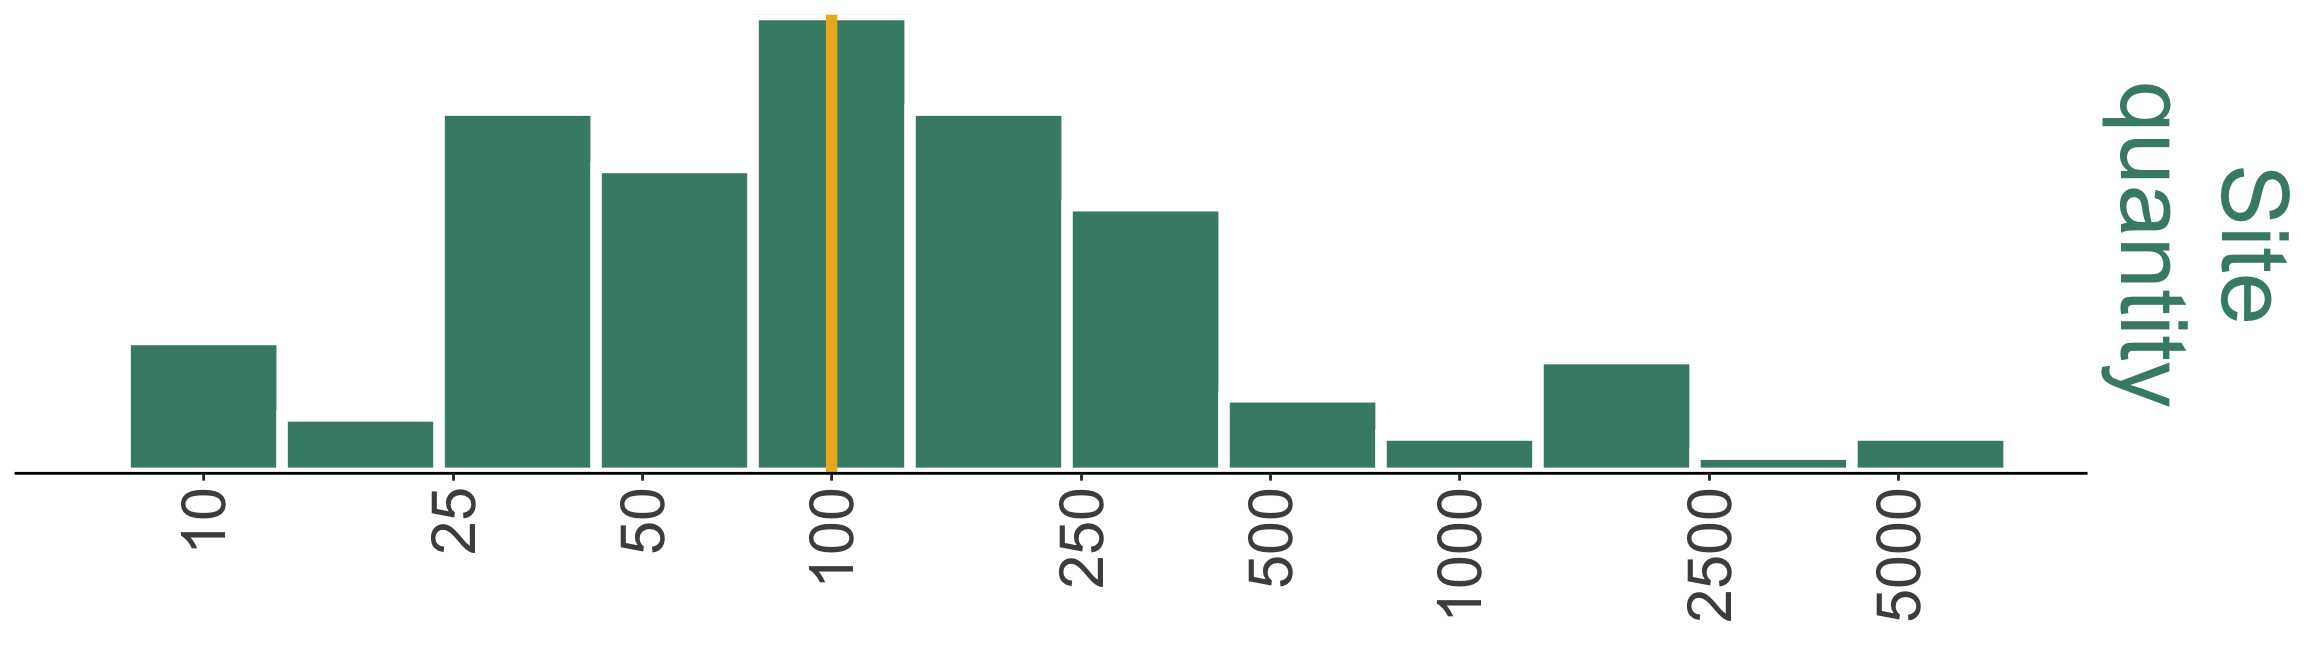

Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).

In [ ]:

siteQuantityPlot <- sheet_DataCollection |>
  mutate(`Site quantity` = as.numeric(`Site quantity`)) |>
  ggplot() +
  geom_histogram(aes(x = `Site quantity`),
                 binwidth = 0.25, fill = "aquamarine4", colour = "white",
                 linewidth = 2) +
  geom_vline(aes(xintercept = median(`Site quantity`, na.rm = TRUE)), 
             colour = "goldenrod2", linetype = 1, linewidth = 2) +
  scale_x_continuous(transform = "log10",
                     limits = c(5, 10000),
                     breaks = c(10, 25, 50, 100, 250, 500,
                                1000, 2500, 5000),
                     expand = c(0,0)) +
  scale_y_continuous(expand = c(0,0), position = "right") +
  labs(y = "Site\nquantity", x = "") +
  theme(panel.grid = element_blank(),
        panel.background = element_rect(fill='transparent', color=NA),
        plot.background = element_rect(fill='transparent', color=NA),
        axis.text.x = element_text(size = 23, angle = 90,
                                   vjust = 0.5, hjust = 1),
        axis.text.y = element_blank(), axis.ticks.y = element_blank(),
        axis.line.x = element_line(), 
        axis.title.y = element_text(size = 35, colour = "aquamarine4"))


In [ ]:
sheet_DataCollection |>
  mutate(`Site quantity` = as.numeric(`Site quantity`)) |>
  summarise(Sites = mean(`Site quantity`, na.rm = TRUE), 
            .by = `Review ID`) |>
  pull(Sites) |>
  median(na.rm = TRUE)


ℹ In argument: `Site quantity = as.numeric(`Site quantity`)`.
Caused by warning:
! NAs introduced by coercion

[1] 103

#### Study duration

(`stat_bin()`).

(`geom_bar()`).

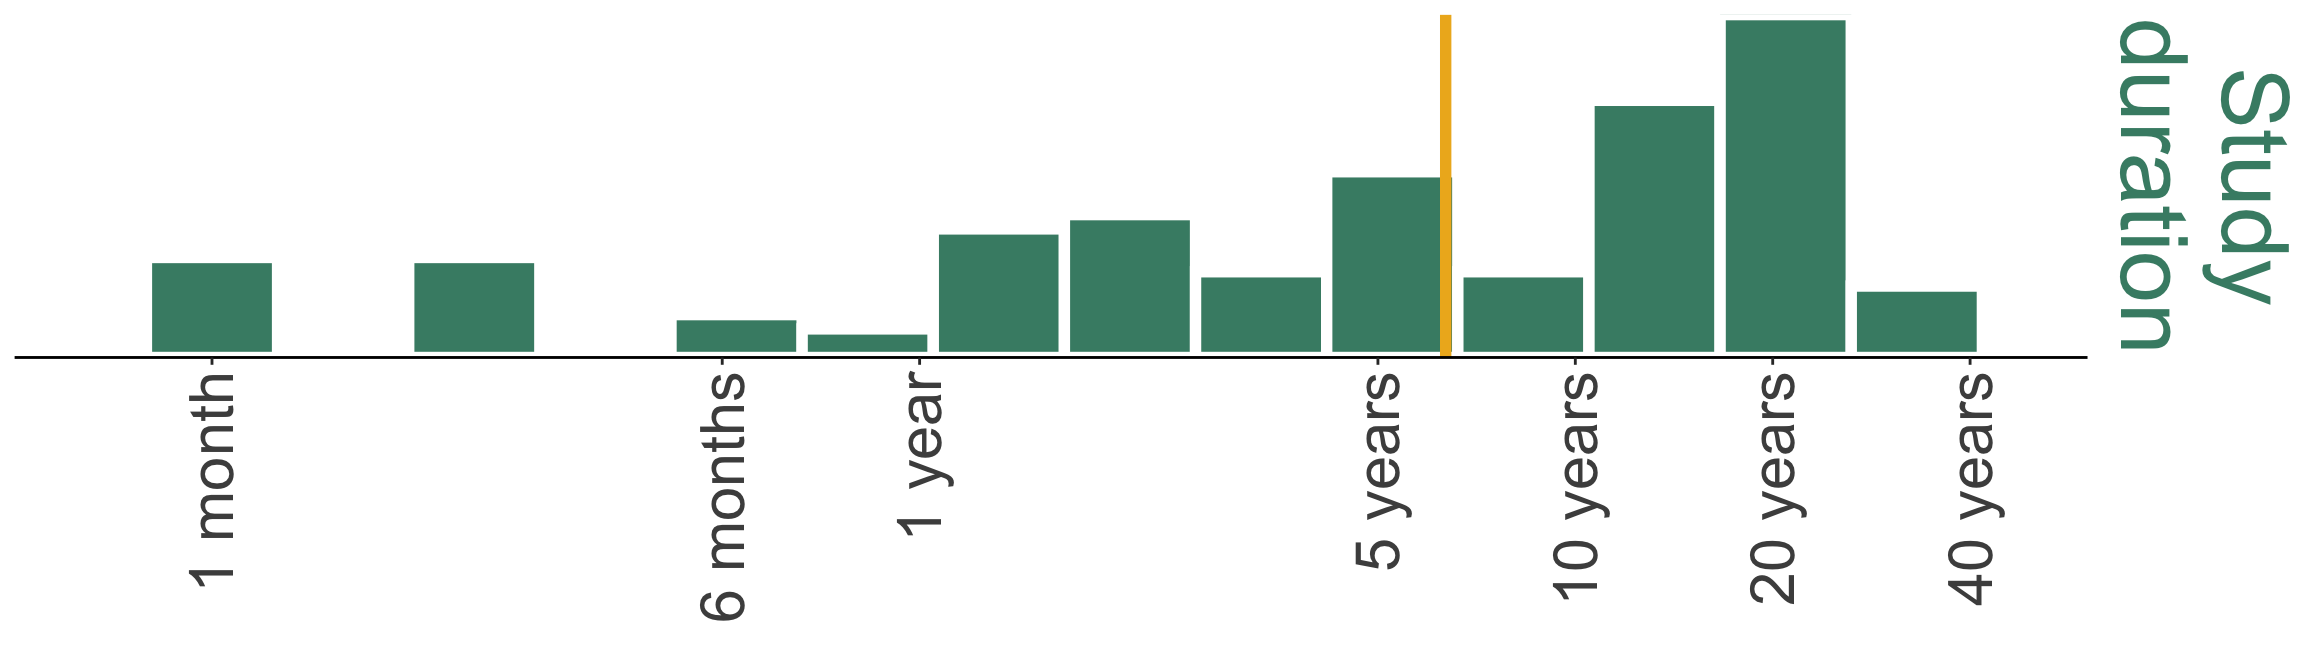

Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).

In [ ]:

studyDurationPlot <-
  sheet_DataCollection |>
    mutate(`Start month` = case_when(str_detect(`Start month`, "[:digit:]{5}") ~ `Start month`,
                                     .default = NA),
           `End month` = case_when(str_detect(`End month`, "[:digit:]{5}") ~ `End month`,
                                     .default = NA)) |>
  mutate(StartDay = as.numeric(as.Date(as.numeric(`Start month`))),
         EndDay = as.numeric(as.Date(as.numeric(`End month`)))) |>
  mutate(StudyDuration = EndDay - StartDay) |>
  mutate(StudyMonths = (StudyDuration/30)) |>
  mutate(StudyMonths = case_when(StudyMonths == 0 ~ 1,
                                 .default = StudyMonths)) |>
  
  ggplot() +
  geom_histogram(aes(x = StudyMonths), 
                 binwidth = 0.2, fill = "aquamarine4", colour = "white",
                 linewidth = 2) +
  geom_vline(aes(xintercept = median(StudyMonths, na.rm = TRUE)), 
             colour = "goldenrod2", linetype = 1, linewidth = 2) +
  labs(x = "", y = "Study\nduration") +
  scale_x_continuous(transform = "log10",
                     limits = c(0.5,725),
                     breaks = c(1, 6, 12, 60, 
                                120, 240, 480), 
                     labels = c("1 month", "6 months", "1 year", "5 years", 
                                "10 years", "20 years", "40 years"),
                     expand = c(0,0)) +
  scale_y_continuous(expand = c(0,0), position = "right") +
  theme(panel.grid = element_blank(),
        panel.background = element_rect(fill='transparent', color=NA),
        plot.background = element_rect(fill='transparent', color=NA),
        axis.text.x = element_text(size = 23, angle = 90,
                                   vjust = 0.5, hjust = 1),
        axis.text.y = element_blank(), axis.ticks.y = element_blank(),
        axis.line.x = element_line(), 
        axis.title.y = element_text(size = 35, colour = "aquamarine4"))
studyDurationPlot


(`stat_bin()`).

(`geom_bar()`).

(`stat_bin()`).

(`geom_bar()`).

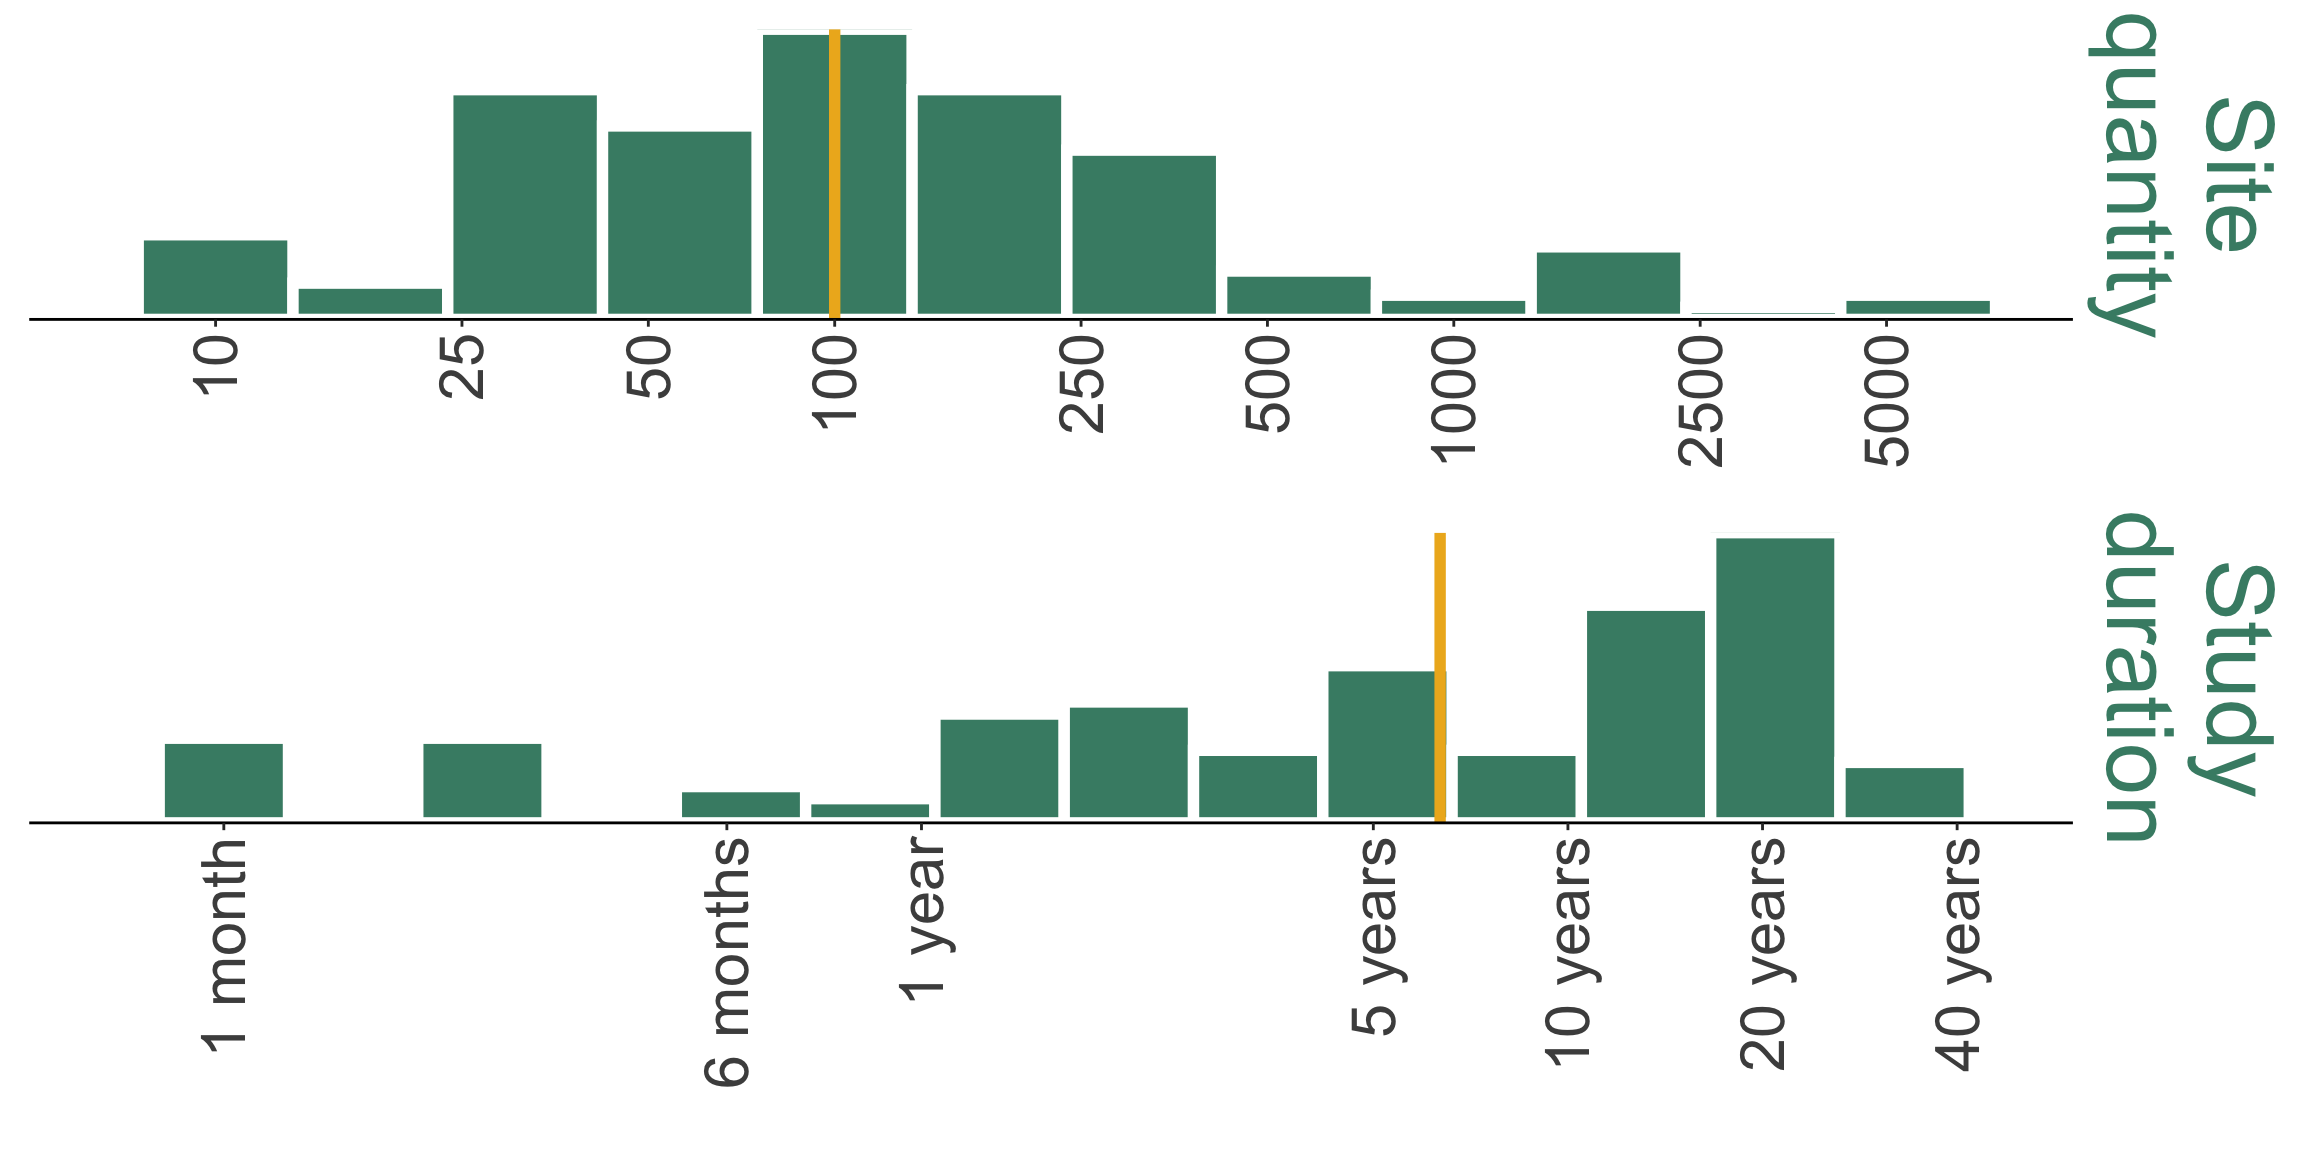

Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).

(`stat_bin()`).

(`geom_bar()`).

In [ ]:

combinedStudyScale <- siteQuantityPlot / studyDurationPlot
combinedStudyScale <- combinedStudyScale +
  theme(panel.background = element_rect(fill='transparent', color = NA),
        plot.background = element_rect(fill='transparent', color = NA))
combinedStudyScale


## Covariates

#### Covariates table

#### Covariates figure

## Modelling

#### Modelling table

## Objectives

#### Objectives statistics

#### Objectives figure

MacKenzie, D. I., Nichols, J. D., Hines, J. E., Knutson, M. G., & Franklin, A. B. (2003). Estimating site occupancy, colonization, and local extinction when a species is detected imperfectly. *Ecology*, *84*(8), 2200–2207. <https://doi.org/10.1890/02-3090>